This notebook is for comparing SEI growth for solvent-limited models in first and second order in the formation context. This is equivalent to Figure 4 in the manuscript.

In [1]:
import pybamm
import numpy as np

no_cycles = 2
exp = pybamm.Experiment(
    [("Charge at C/20 until 4.2 V",
      "Rest for 5 hours",
      "Discharge at C/20 until 2.5 V",
      "Rest for 5 hours",
      )]* no_cycles )



k_sei =[ 7.0e-13, 1e-7, 1e-10]
D_sol = [1e-14,1e-22, 0.8e-22] 
params = []
for i in range(0, len(k_sei)):
  param=pybamm.ParameterValues("Chen2020")
  param.update({'Initial inner SEI thickness [m]':5e-13, 
                 'Initial outer SEI thickness [m]': 5e-13, 
                  'SEI kinetic rate constant [m.s-1]':k_sei[i],
                  'Outer SEI solvent diffusivity [m2.s-1]':D_sol[i],
                  # 'Bulk solvent concentration [mol.m-3]': 4541.0,
                  "Inner SEI reaction proportion": 1.0,
                  "EC initial concentration in electrolyte [mol.m-3]": 4541.0,
                  "EC diffusivity [m2.s-1]": D_sol[i],
                  "SEI open-circuit potential [V]": 0.0,
                  }
  )
  params.append(param)

# setup pybamm model to includ SEI models as well
sei_options = ['ec reaction limited',
               'ec reaction limited', 'ec reaction limited', 
               ]
models = [pybamm.lithium_ion.SPM({"particle": "uniform profile",
                                  "SEI": sei_option}) for sei_option in sei_options]

pybamm.settings.max_y_value = 100000000
solver = pybamm.CasadiSolver(mode="safe")

sims = [pybamm.Simulation(model, parameter_values=params[index],
                          experiment=exp, solver=solver) for index, model in enumerate(models)]
sols = [sim.solve(initial_soc=0) for sim in sims]


/home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests


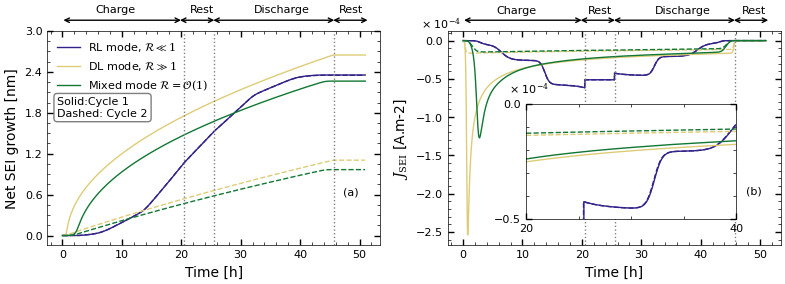

In [2]:
# %cd -
%cd /home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scienceplots
import matplotlib.ticker as ticker
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from style_figs import set_plotting_format

set_plotting_format("paper")  # input should be either "presentation" or "paper"

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

label_models = [
'RL mode, $\mathcal{R} \ll 1$',
'DL mode, $\mathcal{R} \gg 1$',
'Mixed mode $\mathcal{R} = \mathcal{O}(1)$',
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
line_styles = ['-', '--']
# First plot
for index, sol in enumerate(sols):
    color = colors[(1+index) % len(colors)]
    for cycle in range(no_cycles):
        t_min = np.min(sol.cycles[cycle]["Time [h]"].entries)
        t = sol.cycles[cycle]["Time [h]"].entries - t_min
        L_min = np.min(sol.cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries)
        L_sei = (sol.cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries - L_min) * 1e9
        if (cycle == 0):
            axes[0].plot(t, L_sei, label=label_models[index], color=color, linestyle=line_styles[cycle % 2])
        else:
            axes[0].plot(t, L_sei,  color=color, linestyle=line_styles[cycle % 2])

axes[0].set_yticks(np.linspace(0, 3, 6))
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Net SEI growth [nm]")
axes[0].legend()
axes[0].text(0.03, 0.6, 'Solid:Cycle 1\nDashed: Cycle 2',
            transform=axes[0].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Add vertical lines and text at the top of the x-axis for the first plot

axes[0].axvline(x=20.5, color='grey', linestyle=':', linewidth=1)
axes[0].axvline(x=25.5, color='grey', linestyle=':', linewidth=1)
axes[0].axvline(x=45.7, color='grey', linestyle=':', linewidth=1)
axes[0].text(9, 3.27, 'Charge', ha='center')
axes[0].text(23.5, 3.27, 'Rest', ha='center')
axes[0].text(37, 3.27, 'Discharge', ha='center')
axes[0].text(48.5, 3.27, 'Rest', ha='center')
axes[0].text(48.5, 0.6, '(a)', ha='center')

axes[0].annotate('', xy=(0.04, 1.05), xytext=(0.41, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[0].annotate('', xy=(0.39, 1.05), xytext=(0.51, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[0].annotate('', xy=(0.49, 1.05), xytext=(0.87, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[0].annotate('', xy=(0.85, 1.05), xytext=(0.97, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))

# ax2.plot(
#                 t, current,  linestyle=":",  color='gray', alpha=0.3)
# axins = inset_axes(axes[1], width="50%", height="50%",
#                    loc='center')
axins = inset_axes(axes[1], width="70%", height="60%", loc='center',
                   bbox_to_anchor=(0.1, -0.06, 0.9, 0.9), bbox_transform=axes[1].transAxes)
# Second plot
for index, sol in enumerate(sols):
    color = colors[(1+index) % len(colors)]
    for cycle in range(no_cycles):
        t_min = np.min(sol.cycles[cycle]["Time [h]"].entries)
        t = sol.cycles[cycle]["Time [h]"].entries - t_min
        J_sei_last = sol.cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries[0]
        J_sei = sol.cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries - J_sei_last * 0
        axes[1].plot(t, J_sei * 1e4, color=color, linestyle=line_styles[cycle % 2])
        axins.plot(t, J_sei * 1e4, color=color, linestyle=line_styles[cycle % 2])

# Add vertical lines and text at the top of the x-axis for the second plot
axes[1].axvline(x=20.5, color='grey', linestyle=':', linewidth=1)
axes[1].axvline(x=25.5, color='grey', linestyle=':', linewidth=1)
axes[1].axvline(x=45.7, color='grey', linestyle=':', linewidth=1)
axes[1].text(9, 0.35, 'Charge', ha='center')
axes[1].text(23, 0.35, 'Rest', ha='center')
axes[1].text(37, 0.35, 'Discharge', ha='center')
axes[1].text(49,0.35, 'Rest', ha='center')
axes[1].text(49, -2, '(b)', ha='center')

axes[1].annotate('', xy=(0.04, 1.05), xytext=(0.41, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[1].annotate('', xy=(0.39, 1.05), xytext=(0.51, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[1].annotate('', xy=(0.49, 1.05), xytext=(0.87, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))
axes[1].annotate('', xy=(0.85, 1.05), xytext=(0.97, 1.05), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='<->', color='black'))


axes[1].set_xlabel("Time [h]")
axes[1].set_ylabel(
    "$J_\mathrm{SEI}$ [A.m-2] ")
axes[1].text(-0.08, 1.07, '× 10$^{-4}$', transform=axes[1].transAxes,
             verticalalignment='top')
axins.text(-0.08, 1.07, '× 10$^{-4}$', transform=axins.transAxes,
             verticalalignment='bottom')
axins.set_xlim(20, 40)
axins.set_ylim(-0.4, 0)
# Set the locations of the x and y ticks
axins.set_xticks([20, 40])
axins.set_yticks([-0.5, 0])


plt.tight_layout()
plt.savefig("figs/solvent_limited.png", dpi=300)